# Lab 2: Semantic segmentation with Fully Convolutional Networks

#Introduction

## Semantic segmentation

In the previous lab, we used Convolutional Networks to classify images into different classes (numbers, cats/dogs).

Semantic segmentation is a computer vision task that takes classification a step further, by assigning a class to **every pixel** of an image. 

![alt text](https://www.researchgate.net/publication/326875064/figure/fig3/AS:659518916681730@1534252971987/Example-of-2D-semantic-segmentation-Top-input-image-Bottom-prediction.png)

Of course, this problem is much harder than classification. Semantic segmentation is useful for any application that requires a dense classification, such as urban mapping, medical image segmentation, self-driving cars...

## Fully Convolutional Networks

As the name implies, Fully Convolutional Networks (FCNs) are networks that only use convolution operations.

CNNs usually end with some Fully Connected layers for the final classification (we saw that in the previous lab), in
order to output a specific number of values per image.

FCNs on the other end, need to output **a segmentation map** that has the same size as the input image, so the final classification is done by convolutional layers.

For example here is the **SegNet** architecture:

![Segnet architecture](https://www.researchgate.net/profile/Kulsawasd_Jitkajornwanich/publication/318125611/figure/fig2/AS:614349634805761@1523483775045/A-proposed-network-architecture-for-object-segmentation-exponential-linear-unit.png)

As you can see, the network has an "contracting" part and an "expanding" part. This is called an **Encoder-Decoder** architecture. The **Encoder** part computes high-level features using convolution and pooling operations, and the **Decoder** part uses those features and upsamples them to create a segmentation map. Most segmentation neural networks have an architecture like this.

## Skip connections

It is common to directly copy some information from different stages of the encoder, in order to use it in the decoder. It can be pooling indices or even entire feature maps. This restores some high frequency location and boundary information in the encoder, which yields a more global field of view for every pixel and more precise edges. Copying previous information and concatenating in an other part of a network is called a **skip connection**. They can be **short skips** (as in **ResNets**) or **long skips** (as in **U-Nets**).









## What you will learn in this lab



*   How to **create small tiles** from huge satellite/aerial images 
*   How to create a **custom PyTorch Dataset** class
*   How to handle images and **masks**
*   How to do **on-the-fly data augmentation** in PyTorch
*   How to **implement an FCN** (U-Net)
*   How to implement **custom metrics and loss functions** for segmentation

## GPU Runtime

Please check that you are using a GPU runtime! (Runtime -> Change Runtime type)

## Importing Libraries

In [0]:
# Libraries

#PyTorch, of course
import torch
import torch.nn as nn

#We will need torchvision transforms for data augmentation
from torchvision import transforms

### utilities
# tool to print a nice summary of a network, similary to keras' summary
from torchsummary import summary

# library to do bash-like wildcard expansion
import glob

# others
import numpy as np
import random
from PIL import Image
from IPython.display import display
from tqdm import tqdm_notebook


# a little helper function do directly display a Tensor
def display_tensor(t):
  trans = transforms.ToPILImage()
  display(trans(t))

# Part 1: A new kind of dataset

For this lab, we will use the **Inria Aerial Image Labelling Dataset** (https://project.inria.fr/aerialimagelabeling/), which is a high resolution (0.3m/pixel) **building segmentation** dataset that Inria released in 2017. It is already widely used by the scientific community and in industry applications.

It contains **images and corresponding masks**. The mask is white (255) for the *building* class, and black (0) for the *not building* class.

Since this dataset is quite big and takes a long time to download (28GB), we will only work on the **city of Chicago**. Which means we have **36 images of 5000x5000 pixels** (about 1.8GB of data). It is enough for our little experiment, but if we want our method to generalize to other cities, we will need more data. **With Deep Learning, data is key!**

![alt text](https://i.imgur.com/wAL5IUX.png)


## Downloading the data

Run the following code to get the data.

In [0]:
!wget -O chicagopng.zip http://gaetanbahl.engineer/chicagopng.zip

--2019-10-03 09:07:01--  http://gaetanbahl.engineer/chicagopng.zip
Resolving gaetanbahl.engineer (gaetanbahl.engineer)... 95.85.24.80
Connecting to gaetanbahl.engineer (gaetanbahl.engineer)|95.85.24.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1847838926 (1.7G) [application/zip]
Saving to: ‘chicagopng.zip’

chicagopng.zip      100%[===================>]   1.72G   107MB/s    in 16s     

2019-10-03 09:07:18 (107 MB/s) - ‘chicagopng.zip’ saved [1847838926/1847838926]



In [0]:
!unzip -uo chicagopng.zip

Archive:  chicagopng.zip


## Creating small patches

Our images have a size of 5000x5000 pixels. It would be impractical to train a neural network directly on these images, because of memory limitations. We have to make **patches**.

We can do this using ImageMagick's **convert** tool.

In [0]:
#make directories for images and ground truth
!mkdir img_patches
!mkdir gt_patches

# install imagemagick
!apt-get update
!apt-get install imagemagick
!echo "Done!"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:12 https://developer.download.nvidia.com/compute/cuda

In [0]:
#create tiles of 250x250 pixels
#this can take a long time !
!basename -a -s .png $(ls -1 chicagopng/images/) |  xargs -I{} -P 2 convert -crop 250x250 chicagopng/images/{}.png img_patches/{}_%03d.png
!basename -a -s .png $(ls -1 chicagopng/gt/) |  xargs -I{} -P 2 convert -crop 250x250 chicagopng/gt/{}.png gt_patches/{}_%03d.png

In [0]:
# check that the number of patches is correct
!echo "Number of image patches"
!ls -1 img_patches | wc -l
!echo "Number of ground truth patches"
!ls -1 gt_patches | wc -l

Number of image patches
14400
Number of ground truth patches
14400


## Creating a custom Dataset class

In order to load our data, we will need to create our own Dataset subclass. Every segmentation dataset is stored differently, so PyTorch doesn't have a specific class for that.

As you can see in the code below, it is very easy to create a custom dataset class in PyTorch. All we need to implement are the **__len__** and **__getitem__** functions. **len** allows you to run len(mydataset), and **getitem** allows you to access dataset elements like this: **mydataset[i]**



In [0]:
class BinarySegmentationDataset(torch.utils.data.Dataset):
  
  def __init__(self, img_dir, gt_dir):
    
    super().__init__()
    
    # store directory names
    self.img_dir = img_dir
    self.gt_dir = gt_dir
    
    # use glob to get all image names
    self.img_names = [x.split("/")[1] for x in glob.glob(img_dir + "/*")]
    
    # PyTorch transforms
    self.transform = transforms.Compose([transforms.ToTensor()])
  
  def __len__(self):
    return len(self.img_names)
    
  def __getitem__(self,i):
    return self._read_img_and_gt(i)
  
  def _read_img_and_gt(self, i):
    img = Image.open(self.img_dir + "/" + self.img_names[i])
    gt = Image.open(self.gt_dir + "/" + self.img_names[i])
    
    return self.transform(img),self.transform(gt)
    

In [0]:
chicago_data = BinarySegmentationDataset("img_patches", "gt_patches")
print("Number of images in dataset:", len(chicago_data))
print(chicago_data[3])
print(chicago_data[3][0].shape)
print(chicago_data[3][1].shape)

Number of images in dataset: 14400
(tensor([[[0.5451, 0.5059, 0.5059,  ..., 0.5412, 0.5412, 0.5294],
         [0.5255, 0.5098, 0.5451,  ..., 0.5373, 0.5608, 0.5216],
         [0.5137, 0.5294, 0.5451,  ..., 0.5608, 0.5725, 0.5647],
         ...,
         [0.1176, 0.1216, 0.7098,  ..., 0.3882, 0.4431, 0.4706],
         [0.1098, 0.2000, 0.6941,  ..., 0.1843, 0.1490, 0.1686],
         [0.1373, 0.2078, 0.6000,  ..., 0.2353, 0.2118, 0.2196]],

        [[0.5882, 0.5569, 0.5412,  ..., 0.5529, 0.5490, 0.5373],
         [0.5569, 0.5412, 0.5686,  ..., 0.5451, 0.5647, 0.5294],
         [0.5490, 0.5490, 0.5647,  ..., 0.5647, 0.5765, 0.5725],
         ...,
         [0.1412, 0.1373, 0.7216,  ..., 0.4000, 0.4510, 0.4824],
         [0.1412, 0.2157, 0.7176,  ..., 0.2000, 0.1725, 0.1961],
         [0.1294, 0.2078, 0.6157,  ..., 0.2980, 0.2745, 0.2980]],

        [[0.4667, 0.4431, 0.4431,  ..., 0.4667, 0.4706, 0.4627],
         [0.4706, 0.4431, 0.4784,  ..., 0.4667, 0.4784, 0.4588],
         [0.4627, 0.46

## Q1: Displaying some data

Using the **display_tensor()** function, display some patches and their associated ground truth.

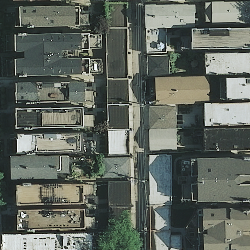

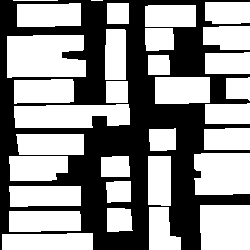

In [0]:
img, gt = chicago_data[1200]

display_tensor(img)
display_tensor(gt)

## Q2: Data augmentation

Since we do not have that much data, we need to "make" more. Data augmentation is very important in Deep Learning, because:

*   There is never enough data
*   Having more data makes the model more robust
*   Having more data can make the training more stable

**Modify the Dataset code to add some random transforms from torchvision.transforms, before the ToTensor transform.**

The documentation is here: https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image

Use transforms such as random flips, random rotations, or anything you like. PyTorch allows you to chain a list of multiple transforms with **transforms.Compose**.





In [0]:
class BinarySegmentationDataset(torch.utils.data.Dataset):
  
  def __init__(self, img_dir, gt_dir):
    
    super().__init__()
    
    # store directory names
    self.img_dir = img_dir
    self.gt_dir = gt_dir
    
    # use glob to get all image names
    self.img_names = [x.split("/")[1] for x in glob.glob(img_dir + "/*")]
    
    # PyTorch transforms
    self.transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomVerticalFlip(p=0.5),
                                             transforms.RandomRotation(10),
                                             transforms.ToTensor()])

  def __len__(self):
    return len(self.img_names)
    
  def __getitem__(self,i):
    return self._read_img_and_gt(i)
  
  def _read_img_and_gt(self, i):
    img = Image.open(self.img_dir + "/" + self.img_names[i])
    gt = Image.open(self.gt_dir + "/" + self.img_names[i])
    
    seed = random.randint(0,2**32) # make a seed with numpy generator 
    
    ## use the same seed for both transforms
    random.seed(seed)
    img = self.transform(img)
    
    random.seed(seed)
    gt = self.transform(gt)
    
    return img, gt
    

## Q3: Check that your data augmentation is working

Display some augmented images in order to check that the images and masks are augmented in the same way. It is very important to do that, otherwise our training will not work properly! **Display the "same" image and masks multiple times to see the effect of data augmentation**. They should be different every time!

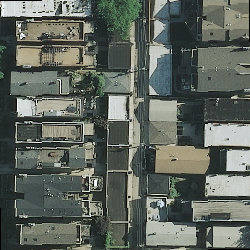

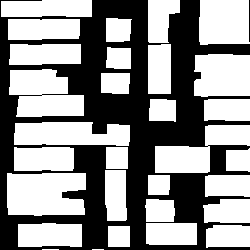

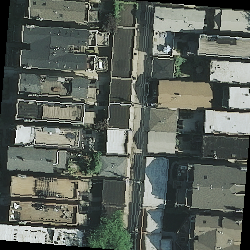

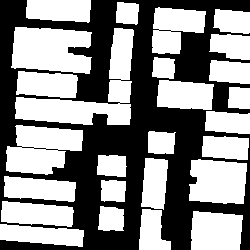

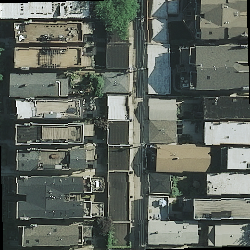

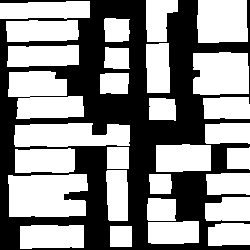

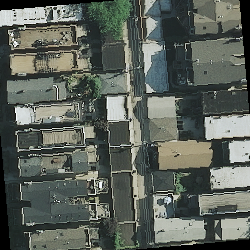

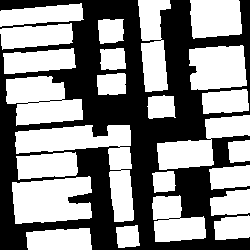

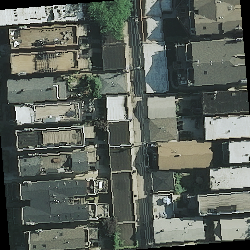

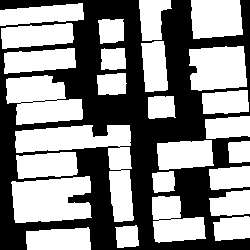

In [0]:
chicago_data = BinarySegmentationDataset("img_patches", "gt_patches")

for i in range(5):
  img, gt = chicago_data[1200]

  display_tensor(img)
  display_tensor(gt)

## Q4: Split the data into train, val and test sets

As in the previous lab, **split the dataset into three subsets (train, val and test)**, then, create DataLoaders for each of these sets.

You can use 10% of the whole set as a test set, and 10% of the rest as the validation set, for example. Feel free to change these percentages!

Pay attention to DataLoader parameters (batch_size, num_workers, shuffle). It is good to shuffle the training set, but useless to shuffle the other sets. "num_workers" allow PyTorch to process your data (and the augmentation) in parallel. This is important if you need to quickly feed data to your GPU to make your training faster.

HINT: use torch.utils.data.random_split twice



In [0]:
test_split = 0.1

val_split = 0.1

N_test_samples = round(test_split * len(chicago_data))
train_and_val_set, test_set = torch.utils.data.random_split(chicago_data, [len(chicago_data) - N_test_samples, N_test_samples])

N_val_samples = round(val_split * len(train_and_val_set))
train_set, val_set = torch.utils.data.random_split(train_and_val_set, [len(train_and_val_set) - N_val_samples, N_val_samples])

print(len(test_set))
print(len(train_set))
print(len(val_set))

train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=2, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=2)


1440
11664
1296


# Part 2: Implementing a U-Net 

For our segmentation network, we will use the well known U-Net architecture (2015).

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## A compact U-Net

However, since U-Net is quite big (millions of parameters) and can take days to train, we will use a modified version of a more compact version of it: C-UNet (https://hal.inria.fr/hal-02277061/document)

Using a compact network will help us get a result faster during the lab. Feel free to implement the full U-Net architecture at home!

Here are the modifications we will do:

* Use 3x3 standard padded convolutions
* Use skip connections
* Return raw logits (no Sigmoid or Softmax)

Thus, our network has the following properties:

* Three "stages" for the encoder, with 2 normal 3x3 convolutions and a max pool for the first two stages
* Two "stages" for the decoder, with 1 transposed convolution and 2 3x3 convolutions per stage
* A non-linearity (ReLU) after each convolution (except the last one)
* Doubling of the number of feature maps at each stage (starting with 8)
* Skip connections (without cropping) between the two first encoder stages and the two decoder stages (see image above)

![alt text](https://i.imgur.com/VavqNFk.png)

## Q5: Implement the neural network

Fill the code below to implement the network.

Do not forget to add an activation layer after each convolution operation. You can use the classic ReLU or any similar activation (eLU, PReLU, etc.) https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

Note that this time, instead of using a Softmax as the last layer, we are returning raw logits (you will see why later). This means that a value above zero is a building, and a value below zero is not a building. **Do not use ReLU after the last convolution layer!**

In [0]:
class CompactUNet(nn.Module):
  
  def __init__(self):
    super(CompactUNet, self).__init__()
    
    ## Encoder
    
    self.conv1_1 = nn.Conv2d(3, 8, 3, padding=1)
    self.conv1_2 = nn.Conv2d(8, 8, 3, padding=1)
    
    self.conv2_1 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)
    
    self.conv3_1 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3_2 = nn.Conv2d(32, 32, 3, padding=1)
    
    ## Decoder
    
    self.up_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2, output_padding=1)
    
    self.conv4_1 = nn.Conv2d(32, 16, 3, padding=1)
    self.conv4_2 = nn.Conv2d(16, 16, 3, padding=1)
    
    self.up_conv2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
    
    self.conv5_1 = nn.Conv2d(16, 8, 3, padding=1)
    self.conv5_2 = nn.Conv2d(8, 8, 3, padding=1)
    
    self.conv1x1 = nn.Conv2d(8, 1, 1)
    
    ## Other layers
    
    self.relu = nn.ReLU()
    
    self.maxpool = nn.MaxPool2d(2)
    
  def forward(self, x):
    
    ##Encoder
    
    #Stage 1
    x = self.conv1_1(x)
    x = self.relu(x)
    
    x = self.conv1_2(x)
    x = self.relu(x)
    
    skip1 = x
    
    #Stage 2
    x = self.maxpool(x)
    
    x = self.conv2_1(x)
    x = self.relu(x)
    
    x = self.conv2_2(x)
    x = self.relu(x)
    
    skip2 = x
    
    #Stage 3
    x = self.maxpool(x)
    
    x = self.conv3_1(x)
    x = self.relu(x)
    
    x = self.conv3_2(x)
    x = self.relu(x)
    
    ##Decoder
    
    #Stage 4
    x = self.up_conv1(x)
    
    x = torch.cat((skip2,x),1)
    
    x = self.conv4_1(x)
    x = self.relu(x)
    
    x = self.conv4_2(x)
    x = self.relu(x)
    
    #Stage 5
    x = self.up_conv2(x)
    
    x = torch.cat((skip1,x),1)
    
    x = self.conv5_1(x)
    x = self.relu(x)
    
    x = self.conv5_2(x)
    x = self.relu(x)
    
    #Output
    x = self.conv1x1(x)
    
    return x

Use the following line to make sure that the forward pass works. Also check that the output shapes are correct. Make sure you understand where the numbers of parameters come from.

In [0]:
summary(CompactUNet().cuda(), (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 250, 250]             224
              ReLU-2          [-1, 8, 250, 250]               0
            Conv2d-3          [-1, 8, 250, 250]             584
              ReLU-4          [-1, 8, 250, 250]               0
         MaxPool2d-5          [-1, 8, 125, 125]               0
            Conv2d-6         [-1, 16, 125, 125]           1,168
              ReLU-7         [-1, 16, 125, 125]               0
            Conv2d-8         [-1, 16, 125, 125]           2,320
              ReLU-9         [-1, 16, 125, 125]               0
        MaxPool2d-10           [-1, 16, 62, 62]               0
           Conv2d-11           [-1, 32, 62, 62]           4,640
             ReLU-12           [-1, 32, 62, 62]               0
           Conv2d-13           [-1, 32, 62, 62]           9,248
             ReLU-14           [-1, 32,

## Q6: Testing the implementation

Try the network on a batch of training data. Also try to display an output mask. Since the network is not trained, the mask should be black.

HINT: to get a single image from an output batch **y**, use y[0,:,:,:]

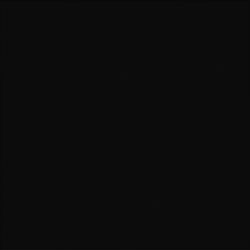

In [0]:
net = CompactUNet()

x = next(iter(train_dl))[0]
y = net(x)

display_tensor(y[0,:,:,:])

# Part 3: Training a segmentation network

Training a segmentation is not that much different from training a classifier. 

The type of output is different, so we will need new metrics and perhaps a new loss.

## Specific metrics for segmentation

As a metric, **accuracy** is not always very good, especially when your data is imbalanced (which happens a lot in real life). For example, with medical image segmentation, the objects to detect are often very small compared to the size of the image. So it is sometimes possible to get 99% accuracy by not segmenting anything. 

Our Chicago dataset has around 25% of building pixels, so it is *imbalanced* but not *too much*.


Here is a good example of extreme imbalance. In this image, we are looking for a small tumor:

![alt text](https://d3i71xaburhd42.cloudfront.net/1733583ca8de32ec5ff0526443b46db44f677b3e/3-Figure2-1.png)

This is why we need **other metrics, such as IoU (Intersection over Union), Precision, Recall or Specificity,** which are more representative of what is really happening.

**IoU, also called Jaccard coefficient**, is used a lot in (binary) segmentation, because it only takes into account the parts of the image that actually need to be segmented:

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png)

The **Dice coefficient** is another widely used metric, similar to IoU: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

Here is an implementation of IoU:

In [0]:
def iou_metric(logits, target):
  
  ## get a bool array for logits and labels
  # for logits, above 0 is building, below 0 is non-building
  logits = logits > 0
  # for labels (between 0 and 1), 1 is building, 0 is non-building
  target = target > 0.5
  
  #compute IoU
  intersection = logits * target
  union = logits + target
  return float(intersection.sum()) / float(union.sum())

## Loss and optimizer

The output of our network is a single class, so we can use the **Binary Cross Entropy loss**. Since we did not put a sigmoid activation layer after the last convolutional layer, we will use** BCEWithLogitsLoss**. Otherwise, we would have to use BCELoss, which is less stable. It is good to look at the PyTorch documentation to know what's what: https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss

I put **Adam** as the optimizer here, but you can try anything from torch.optim. **Adam has an adaptive learning rate** for each weight of the network. The original learning rate is just an upper bound. This optimizer can allow you to reach a better local minimum, sometimes. Check the original paper for more info: https://arxiv.org/abs/1412.6980

In [0]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

# feel free to change the learning rate!
LEARNING_RATE = 0.001

## Create an instance of our network
net = CompactUNet()

## Move it to the GPU
net = net.cuda()

# Binary Cross Entropy loss
bce_loss = nn.BCEWithLogitsLoss()

# Adam optimizer. you can try another one if you want.
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Q7: Training loop

Fill the code below to create the training and validation loops.

In [0]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 20

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  running_iou = 0
  n_pixels = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm_notebook(train_dl)):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = jaccard_bce_loss(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      y_bool = y > 0
      labels_bool = labels > 0.5
      running_accuracy += (y_bool == labels_bool).sum().item()
      n_pixels += np.prod(labels_bool.size())
      
      running_iou += iou_metric(y, labels)    
    
  print("Training accuracy:", running_accuracy/n_pixels,
        "Training loss:", running_loss/float(len(train_dl)),
        "Training IoU:", running_iou/float(len(train_dl)))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  running_val_iou = 0
  n_pixels = 0
  
  for i, batch in enumerate(val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y = net(x)
      
      # Compute the loss
      loss = jaccard_bce_loss(y, labels)
      running_val_loss += loss.item()
      
      y_bool = y > 0
      labels_bool = labels > 0.5
      
      running_val_accuracy += (y_bool == labels_bool).sum().item()
      n_pixels += np.prod(labels_bool.size())
      
      running_val_iou += iou_metric(y, labels)

    
  print("Validation accuracy:", running_val_accuracy/(1e-7 + n_pixels),
        "Validation loss:", running_val_loss/float(len(val_dl)),
        "Validation IoU:", running_val_iou/float(len(val_dl)))
      

EPOCH: 0



Training accuracy: 0.7641417736625514 Training loss: 0.5531202606958886 Training IoU: 0.17556862382369245
Validation accuracy: 0.8144518148148138 Validation loss: 0.49414428341679456 Validation IoU: 0.2590295932224031
EPOCH: 1



Training accuracy: 0.8145128504801097 Training loss: 0.48186439847292967 Training IoU: 0.2766833708807071
Validation accuracy: 0.8095883333333322 Validation loss: 0.47902799815666386 Validation IoU: 0.38345524174428997
EPOCH: 2



Training accuracy: 0.825962987654321 Training loss: 0.4561858927550381 Training IoU: 0.3460262851792733
Validation accuracy: 0.8333119012345668 Validation loss: 0.447262662939909 Validation IoU: 0.3479628357131282
EPOCH: 3



Training accuracy: 0.8333509039780521 Training loss: 0.44336056080583025 Training IoU: 0.37875748431131456
Validation accuracy: 0.842228185185184 Validation loss: 0.43169468713969716 Validation IoU: 0.40457670470555884
EPOCH: 4



Training accuracy: 0.8374803360768176 Training loss: 0.4382923943539188 Training IoU: 0.39647856604415616
Validation accuracy: 0.8319438395061718 Validation loss: 0.44242931938752894 Validation IoU: 0.3200675031003165
EPOCH: 5



Training accuracy: 0.844730706447188 Training loss: 0.4279031825392214 Training IoU: 0.42420166274636684
Validation accuracy: 0.851256123456789 Validation loss: 0.42008671382578405 Validation IoU: 0.44993898740770966
EPOCH: 6



Training accuracy: 0.8472454650205762 Training loss: 0.4234119803938147 Training IoU: 0.4326884792646823
Validation accuracy: 0.8492483580246902 Validation loss: 0.4214560215066119 Validation IoU: 0.4297483549251673
EPOCH: 7



Training accuracy: 0.8514795925925925 Training loss: 0.41768788899460885 Training IoU: 0.44872898769209657
Validation accuracy: 0.8509899135802458 Validation loss: 0.417238052298383 Validation IoU: 0.4142535608931543
EPOCH: 8



Training accuracy: 0.8514571906721536 Training loss: 0.4162049550716191 Training IoU: 0.4500641116876967
Validation accuracy: 0.8581109135802458 Validation loss: 0.4093122794860747 Validation IoU: 0.4805879919891154
EPOCH: 9



Training accuracy: 0.8555464252400549 Training loss: 0.41103501817951466 Training IoU: 0.4634113166974803
Validation accuracy: 0.8521148395061717 Validation loss: 0.41738254558749316 Validation IoU: 0.49748032099925005
EPOCH: 10



Training accuracy: 0.8562648792866941 Training loss: 0.40971249039858987 Training IoU: 0.4659740997962281
Validation accuracy: 0.8588198395061717 Validation loss: 0.403173788291652 Validation IoU: 0.4623134555290318
EPOCH: 11



Training accuracy: 0.8569967050754458 Training loss: 0.4079127150855652 Training IoU: 0.4702953543472176
Validation accuracy: 0.8599687777777767 Validation loss: 0.4079681678516109 Validation IoU: 0.5064462654628813
EPOCH: 12



Training accuracy: 0.8592192592592592 Training loss: 0.4039334738091247 Training IoU: 0.47708126930467293
Validation accuracy: 0.8616955555555544 Validation loss: 0.401966368279806 Validation IoU: 0.4862619114436295
EPOCH: 13



Training accuracy: 0.8596528010973937 Training loss: 0.4034839643190985 Training IoU: 0.4805539767786039
Validation accuracy: 0.8572799506172828 Validation loss: 0.40815033636442044 Validation IoU: 0.440291262130182
EPOCH: 14



Training accuracy: 0.8616331659807956 Training loss: 0.39981735928417883 Training IoU: 0.4877207713249131
Validation accuracy: 0.8616113456790112 Validation loss: 0.3995603998986686 Validation IoU: 0.47990635960291894
EPOCH: 15



Training accuracy: 0.861680695473251 Training loss: 0.39956434132301644 Training IoU: 0.48868429510138817
Validation accuracy: 0.8571152592592581 Validation loss: 0.4028049489346946 Validation IoU: 0.43999599251481064
EPOCH: 16



Training accuracy: 0.862574829903978 Training loss: 0.3978801947750457 Training IoU: 0.49181899946533286
Validation accuracy: 0.864555148148147 Validation loss: 0.3971661939853575 Validation IoU: 0.48968589391007644
EPOCH: 17



Training accuracy: 0.8634687873799726 Training loss: 0.39554187900399507 Training IoU: 0.496526244834511
Validation accuracy: 0.8642805679012334 Validation loss: 0.3981409516276383 Validation IoU: 0.5241672487325015
EPOCH: 18



Training accuracy: 0.864228853223594 Training loss: 0.3943841859085919 Training IoU: 0.5007388161773798
Validation accuracy: 0.8645876790123446 Validation loss: 0.39256754517555237 Validation IoU: 0.48464572586050436
EPOCH: 19



Training accuracy: 0.8642377668038409 Training loss: 0.39391334252814725 Training IoU: 0.5030904418899593
Validation accuracy: 0.8656453950617273 Validation loss: 0.39258883057571037 Validation IoU: 0.49631300020910124


## Q8: Test loop

Using the test dataloader you created, write a test loop (similar to a val loop). You should get about 85% accuracy.

In [0]:
net.eval()

test_loss = 0
test_accuracy = 0
n_pixels = 0

for i, batch in enumerate(test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = bce_loss(y, labels)
    y = y > 0.5
    labels = labels > 0.5
    test_loss += loss.item()
    test_accuracy += (y == labels).sum().item()
    n_pixels += np.prod(labels.size())

print("Test accuracy:", test_accuracy/n_pixels,
      "Test loss:", test_loss/float(len(test_dl)))

Test accuracy: 0.8535168555555556 Test loss: 0.33079981009165443


## Q9: Visualizing some test results

Visualize a few images from the test set, along with the neural network output and the associated ground truth. 

Are the results good? Do you notice particular cases where the network fails?

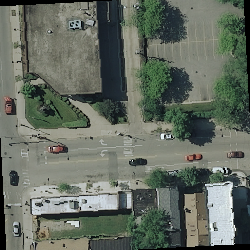

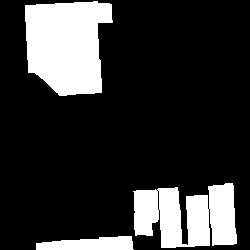

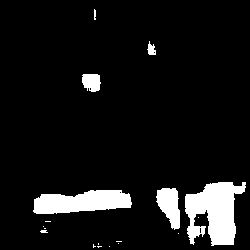

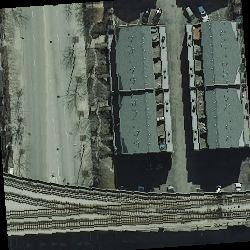

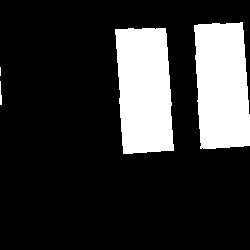

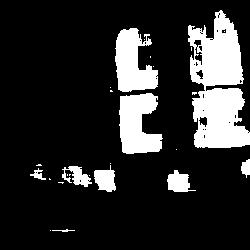

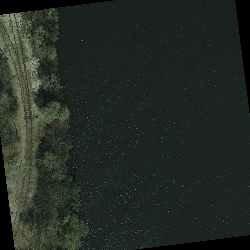

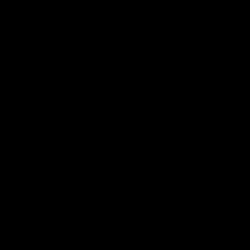

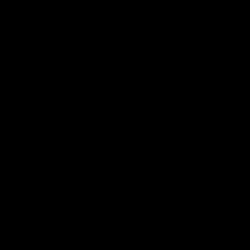

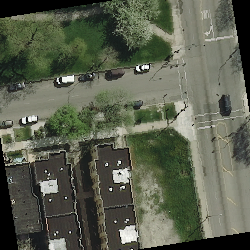

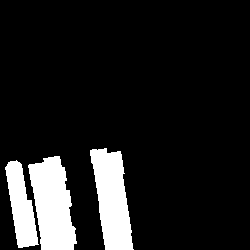

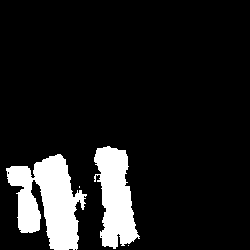

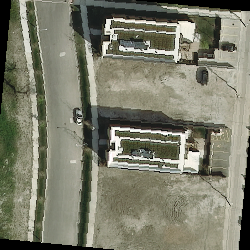

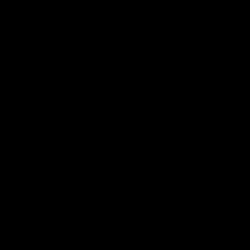

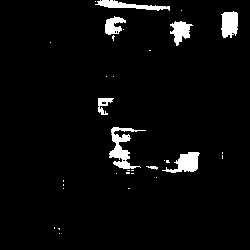

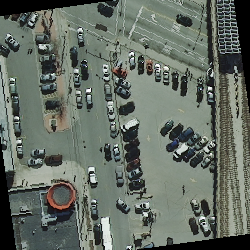

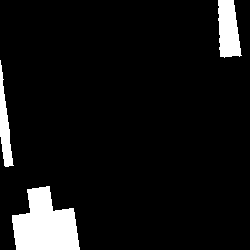

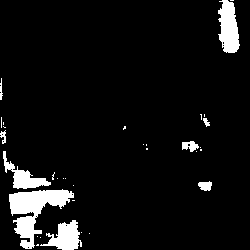

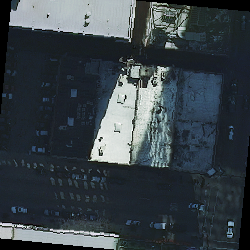

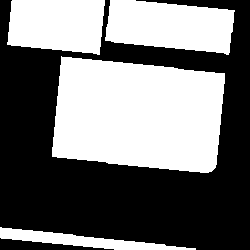

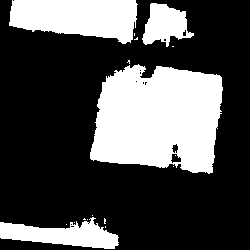

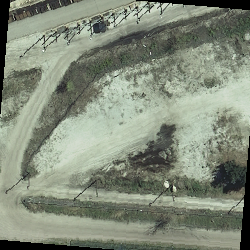

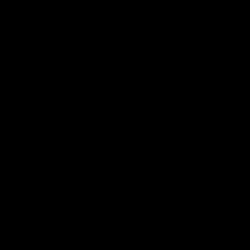

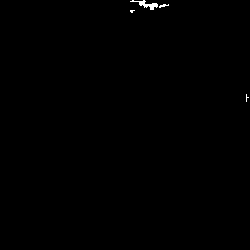

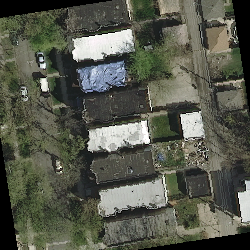

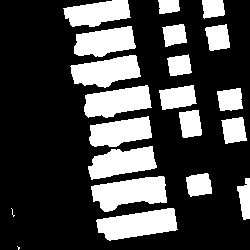

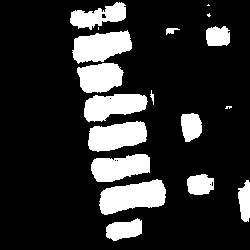

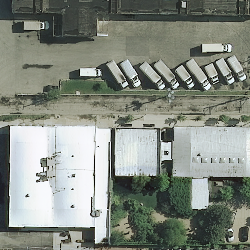

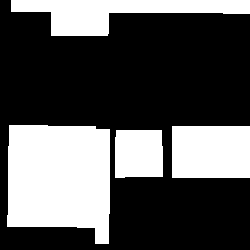

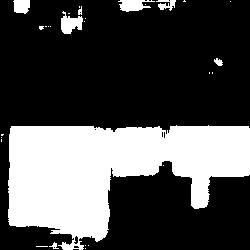

In [0]:
iter_dl = iter(test_dl)
batch = next(iter_dl)
batch = next(iter_dl)
y = net(batch[0].cuda())

for i in range(10):
  display_tensor(batch[0][i,:,:,:])
  display_tensor(batch[1][i,:,:,:])
  display_tensor((y[i,:,:,:].cpu() > 0).type(torch.FloatTensor))



## Specific losses for segmentation tasks

The choice of the loss function is important in Deep learning, because **it determines what we are optimizing for**. In the case of binary cross-entropy, we are purely optimizing for the best pixel-by-pixel accuracy. While it works in our quite balanced dataset, it may not work in others.

Since we are also measuring the IoU, it would be interesting to build an IoU-based loss function that tries to get us **a better IoU**.

Some other loss functions, such as Focal Loss, focus the training on hard examples. This can also be good for unbalanced semantic segmentation https://arxiv.org/abs/1708.02002

## Q10: Jaccard (IoU) loss

Let's implement the Jaccard loss. Fill the code below and replace the loss we used earlier (in the training loop) by the sum of binary cross entropy and jaccard loss. The loss looks like the metric we implemented earlier, except we are using 1 - "metric" because PyTorch tries to **minimize** a loss.

![alt text](http://cv.cs.nthu.edu.tw/upload/undergraduate/Skin_Lesion_Segmentation_Attribute_Detection_and_Classification_via_Deep_Learning/images/loss%20function.png)

Please note that we are mixing the Jaccard loss with the Binary Cross Entropy loss with some *alpha* and *beta* coefficients. **You can try to change them to give more importance to accuracy or to IoU**.

Then, relaunch the training with a new network. Do you get better results? Can you see a difference in the output masks?

In [0]:
def jaccard_loss(logits, true):
    eps = 1e-7

    iflat = logits.view(-1)
    tflat = true.view(-1)
    intersection = (iflat * tflat).sum()
    union = iflat.sum() + tflat.sum() - intersection
    return 1 - ((intersection) / (union + eps))
  
def jaccard_bce_loss(logits, true, alpha=0.1, beta=0.9):
  
  return alpha * jaccard_loss(logits, true) + beta * bce_loss(logits, true)

## (OPTIONAL) Q11: Going further

Now that you have trained a basic U-Net for binary segmentation, you can do different things to get better results:



*   Play with the training hyper-parameters (learning rate, batch size, optimizers, loss functions)
*   Try to modify the network (add layers, try a bigger network, try a network from torchvision)
*   Implement the dice coefficient and the dice loss
*   Try using the whole dataset, it is available here https://project.inria.fr/aerialimagelabeling/



# (OPTIONAL) Part 4: Urban (Self-driving) dataset

Cityscapes is a very popular street-level urban segmentation dataset https://www.cityscapes-dataset.com/

![Texte alternatif…](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/exampleFeaturedImage-270x250.png)

There is a Cityscapes dataset class in Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html#cityscapes

Using what you learned thus far and semantic segmentation models from torchvision (ttps://pytorch.org/docs/stable/torchvision/models.html#semantic-segmentation), you can train the kind of neural network that would be used in a self-driving car! 


# (OPTIONAL) Part 5: Kaggle segmentation datasets

A lot of Kaggle competitions involve binary or multi-class segmentation. Here are some of them:

**(Some) Past competitions:**

Pneumothorax segmentation https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation

![Texte alternatif…](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F268751%2Fd91f3137f0cb884ce317eb10d9c174f0%2F1.2.276.0.7230010.3.1.4.8323329.475.1517875163.123986.png?generation=1563095072265245&alt=media)

Carvana car segmentation https://www.kaggle.com/c/carvana-image-masking-challenge

![Texte alternatif…](https://i1.wp.com/blog.kaggle.com/wp-content/uploads/2017/12/E.png?resize=1024%2C335)

**Current competitions:**

Cloud segmentation https://www.kaggle.com/c/understanding_cloud_organization

![Texte alternatif…](https://storage.googleapis.com/kaggle-media/competitions/MaxPlanck/Teaser_AnimationwLabels.gif)

Try to use state-of-the-art models to climb the leaderboards!

Have fun!